In [46]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import *
from tensorflow.keras.models import * 
from tensorflow.keras.preprocessing import image
import scipy
import os
import random
import shutil
# import joblib

In [47]:
train_set = "D:/Research/Oral Cancer Detection/Data/Mendeley Data/100x_Split_dataset_v2/train"
test_set = "D:/Research/Oral Cancer Detection/Data/Mendeley Data/100x_Split_dataset_v2/test"
validation_set = "D:/Research/Oral Cancer Detection/Data/Mendeley Data/100x_Split_dataset_v2/validate"

In [48]:
train_set

'D:/Research/Oral Cancer Detection/Data/Mendeley Data/100x_Split_dataset_v2/train'

In [49]:
train_datagen = image.ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1)
validation_datagen= image.ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1)
test_datagen= image.ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1)

In [50]:
train_generator = train_datagen.flow_from_directory(
    train_set,
    target_size = (224,224),
    batch_size = 16,
    class_mode = 'binary')
validation_generator = validation_datagen.flow_from_directory(
    validation_set,
    target_size = (224,224),
    batch_size = 16,
    shuffle=True,
    class_mode = 'binary')
test_generator = test_datagen.flow_from_directory(
    test_set,
    target_size = (224,224),
    batch_size = 16,
    class_mode = 'binary')

Found 480 images belonging to 2 classes.
Found 149 images belonging to 2 classes.
Found 133 images belonging to 2 classes.


In [51]:
train_generator.class_indices

{'Normal': 0, 'OSCC': 1}

In [52]:
base_for_model = tf.keras.applications.VGG19(weights='imagenet', input_shape=(224,224,3), include_top=False)

In [53]:
for layer in base_for_model.layers:
    layer.trainable = False

In [54]:
model = Sequential()
model.add(base_for_model) 
model.add(GaussianNoise(0.25)) #to prevent overfitting
model.add(GlobalAveragePooling2D()) #to converge and reduce the parameters
model.add(Dense(512, activation = 'relu')) #hidden layer (relu activation function is suggested for images)
model.add(BatchNormalization()) #to prevent overfitting
model.add(Dense(1, activation='sigmoid')) #output layer
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 gaussian_noise_2 (GaussianN  (None, 7, 7, 512)        0         
 oise)                                                           
                                                                 
 global_average_pooling2d_2   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 batch_normalization_2 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                      

In [55]:
adam= tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=adam,loss= 'binary_crossentropy', metrics=['accuracy','Precision','Recall','AUC'])

In [56]:
mp= tf.keras.callbacks.ModelCheckpoint(filepath='vgg19.hdf5',verbose=2, save_best_only=True)
es= tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.05, patience=3)
callback=[es,mp]

In [57]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9686404986799681717
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 881848320
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8861095484025836365
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [58]:
print(tf.test.is_gpu_available())

True


In [59]:
history = model.fit(
    train_generator,
#     steps_per_epoch= 4946/32,
    epochs = 10, #own choice
    validation_data = validation_generator,
    callbacks=callback
)

Epoch 1/10
30/30 [==============================] - ETA: 0s - loss: 0.6332 - accuracy: 0.6896 - precision: 0.9273 - recall: 0.6768 - auc: 0.7694
Epoch 1: val_loss improved from inf to 0.53050, saving model to vgg19.hdf5
30/30 [==============================] - 30s 981ms/step - loss: 0.6332 - accuracy: 0.6896 - precision: 0.9273 - recall: 0.6768 - auc: 0.7694 - val_loss: 0.5305 - val_accuracy: 0.8188 - val_precision: 0.9450 - val_recall: 0.8306 - val_auc: 0.8144
Epoch 2/10
30/30 [==============================] - ETA: 0s - loss: 0.3743 - accuracy: 0.8479 - precision: 0.9449 - recall: 0.8662 - auc: 0.8907
Epoch 2: val_loss did not improve from 0.53050
30/30 [==============================] - 29s 975ms/step - loss: 0.3743 - accuracy: 0.8479 - precision: 0.9449 - recall: 0.8662 - auc: 0.8907 - val_loss: 1.4764 - val_accuracy: 0.4430 - val_precision: 1.0000 - val_recall: 0.3306 - val_auc: 0.9316
Epoch 3/10
30/30 [==============================] - ETA: 0s - loss: 0.2921 - accuracy: 0.8708 - 

In [60]:
print(history.history.keys())
acc=(history.history['accuracy'])
loss=(history.history['loss'])
prc=(history.history['precision'])
rec=(history.history['recall'])
auc=(history.history['auc'])
val_acc=(history.history['val_accuracy'])
val_loss=(history.history['val_loss'])
val_prc=(history.history['val_precision'])
val_rec=(history.history['val_recall'])
val_auc=(history.history['val_auc'])

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'auc', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc'])


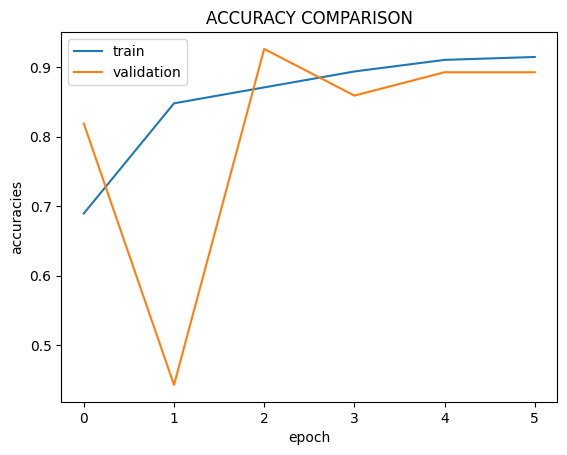

In [61]:
plt.plot(acc)
plt.plot(val_acc)
plt.title('ACCURACY COMPARISON')
plt.xlabel('epoch')
plt.ylabel('accuracies')
plt.title('ACCURACY COMPARISON')
plt.legend(['train','validation'])

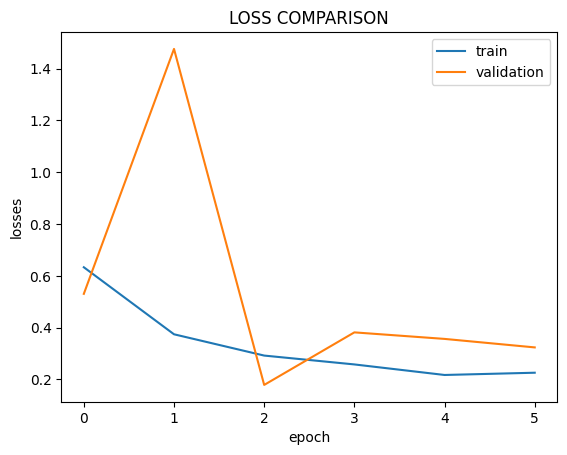

In [62]:
plt.title('LOSS COMPARISON')
plt.plot(loss)
plt.plot(val_loss)
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['train','validation'])

In [ ]:
print("Model Train Evaluation")
model.evaluate(train_generator)
print("Model Validation Evaluation")
model.evaluate(validation_generator)
print("Model Test Evaluation")
model.evaluate(test_generator)

Model Train Evaluation
19/30 [==================>...........] - ETA: 6s - loss: 0.2819 - accuracy: 0.8882 - precision: 0.9828 - recall: 0.8837 - auc: 0.9607

In [ ]:
img =(image.load_img('D:/Research/Oral Cancer Detection/Data/Mendeley Data/First Set/100x Normal Oral Cavity Histopathological Images/Normal_100x_12.jpg',target_size=(224,224)))
imaga = image.img_to_array(img)
image = np.expand_dims(imaga,axis=0)  
ypred = model.predict(image)
if ypred<0.5:
      ypred="Normal"
else:
      ypred="Squamous Cell Carcinoma" 
plt.imshow(img)
ypred

In [45]:
model.save("vgg19.h5")
print("Saved model to disk")

Saved model to disk
